**Import**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import xgboost
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

**EDA**

In [5]:
train_data = pd.read_csv('/content/train.csv')
train_data.drop(['id'], axis=1, inplace=True)

In [6]:
CATEGORICAL_COLUMNS = train_data.select_dtypes(include=[object]).columns
NUMERICAL_COLUMNS = train_data.select_dtypes(include=['int64', 'float64']).columns
print("Total numerical features ",len(NUMERICAL_COLUMNS))
print("Total categorical features ",len(CATEGORICAL_COLUMNS))

Total numerical features  29
Total categorical features  5


In [7]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
zipcode,24235.0,18030.844564,1477.571555,15001.000000,17111.000000,18944.000000,19128.000000,19611.000000
latitude,24269.0,40.080788,1.637096,-12.116930,39.966766,40.130169,40.444389,61.218056
longitude,24269.0,-77.241598,5.817313,-149.900278,-77.008588,-75.475763,-75.185042,-11.706829
cemetery_dist_miles,24269.0,1.206987,0.927508,0.022214,0.818566,1.019586,1.227709,9.747778
nationalhighway_miles,24269.0,0.290908,0.364962,0.000027,0.143624,0.206222,0.281964,7.920969
railline_miles,24269.0,1.049048,1.574878,0.000248,0.465909,0.629888,0.860038,28.306430
starbucks_miles,24269.0,2.042534,3.205261,0.013197,0.959076,1.348776,1.789913,63.618152
walmart_miles,24269.0,3.528326,1.794201,0.118545,2.712467,3.326397,3.870699,26.409748
hospital_miles,24269.0,2.269302,2.467797,0.041096,1.160151,1.584675,2.196950,32.433629
physician_dist_miles,24269.0,0.352973,0.551741,0.000087,0.170974,0.229126,0.299176,14.301216


In [8]:
#Many Numerical features are at different scale
#Number of beds ranging from 1-18
#Area range 35-5000
#garage mostly 0
#year built----25% house before 1960, 50% with 1960 and rest 25% > 1960 and max is 2016
#With Pool is very rare
#fireplace is very rare
#patio very rare
#Lot size min value is very less compared to 25th percentile
#Census_MedianIncome min value is very less compared to 25th percentile
#for Rent big gap between 75th percentile and max value
#Zipcode, year build should not be in numeric list
#Feature Eng--bed, bath, halfbath

(array([1.8568e+04, 4.8710e+03, 6.1500e+02, 1.2100e+02, 5.1000e+01,
        2.2000e+01, 1.1000e+01, 6.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([  385. ,  1946.5,  3508. ,  5069.5,  6631. ,  8192.5,  9754. ,
        11315.5, 12877. , 14438.5, 16000. ]),
 <a list of 10 Patch objects>)

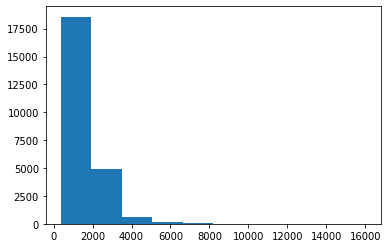

In [9]:
plt.hist(train_data['rent'])

In [10]:
#Analyze columns with missing values
percent_missing = train_data.isnull().sum() * 100 / len(train_data)
missing_value_df = pd.DataFrame({'column_name': train_data.columns,
                                 'percent_missing': percent_missing})
missing_value_df[missing_value_df['percent_missing'] > 0].head(100)

,column_name,percent_missing
county,county,0.140096
zipcode,zipcode,0.140096
address,address,3.922700
property_type,property_type,14.940871


**Define Master Data**

In [11]:
#Get mode for columns having missing values, will be used for test data as well
impute_county = train_data['county'].mode().values[0]
impute_zipcode = train_data['zipcode'].mode().values[0]
impute_property_type = train_data['property_type'].mode().values[0]
#Define list of columns for standardscaler
exlude_columns = ['zipcode', 'yearbuilt', 'bed', 'bath', 'halfbath', 'garage', 'pool', 'fireplace', 'patio', 'rent']
columns_for_std = list(set(train_data.select_dtypes(include=['int64', 'float64']).columns) - set(exlude_columns))
cat_columns = train_data.select_dtypes(include=[object]).columns
#Standardization
scale = StandardScaler()
scale.fit(train_data[columns_for_std])
#Create dictionary for zip code
dict_zip_code = {}
for idx, zc in enumerate(train_data['zipcode'].unique()):
  dict_zip_code[zc] = idx
#Create dictionary for city
dict_city = {}
for idx, city in enumerate(train_data['city'].unique()):
  dict_city[city] = idx
#Create dictionary for county
dict_county = {}
for idx, county in enumerate(train_data['county'].unique()):
  dict_county[county] = idx
#Default value
default_zipcode = dict_zip_code[train_data['zipcode'].mode()[0]]
default_city = dict_city[train_data['city'].mode()[0]]

**Pre Processing**

In [12]:
def preprocessing(data):
    """Function to preprocess the data"""
    #Change Data type for zip code
    convert_dict = {'zipcode':'object'}
    data = data.astype(convert_dict)

    #Missing value imputation
    data.county = data.county.fillna(impute_county)
    data.zipcode = data.zipcode.fillna(impute_zipcode)
    data.property_type = data.property_type.fillna(impute_property_type)
    
    #Transform numeric columns
    transformed_data = pd.DataFrame(data=scale.transform(data[columns_for_std]), columns=columns_for_std)

    #Get remaining column
    remaining_columns = exlude_columns
    for col in cat_columns:
      remaining_columns.append(col)
    remaining_data = data[list(set(remaining_columns))]
    
    #Merge both data
    transformed_data.reset_index(drop=True, inplace=True)
    remaining_data.reset_index(drop=True, inplace=True)
    all_data = pd.concat([transformed_data, remaining_data], axis=1)
    return all_data

**Feature selection**

In [13]:
#Step1
#Check if redundant features present
def get_redundant_features(preprocessed_data, thrld):
  df_corr = preprocessed_data[preprocessed_data.select_dtypes(include=['int64', 'float64']).columns].corr()
  for index, row in df_corr.iterrows():
    correlated_indices = []
    for idx, val in enumerate(row):
      if val > thrld:
        correlated_indices.append(idx)
    correlated_columns = df_corr.columns[correlated_indices]
    if len(correlated_columns) > 1:
      print('Feature: {} is correlated with-- {}'.format(index, correlated_columns))

In [14]:
get_redundant_features(train_data, .8)

Feature: dentist_dist_miles is correlated with-- Index(['dentist_dist_miles', 'opt_dist_miles'], dtype='object')
Feature: opt_dist_miles is correlated with-- Index(['dentist_dist_miles', 'opt_dist_miles'], dtype='object')


In [15]:
#Above two features are highly correlated so we will select any one from them
exclude_list = ['dentist_dist_miles']

**Feature Engineering**

In [16]:
def plot_data(data, col, stat_type, plot_type='line'):
  '''Plot feature and target stat'''
  if stat_type == 'count':
    grp_data = data.groupby(col, as_index=False)['rent'].count()
  else:
    grp_data = data.groupby(col, as_index=False)['rent'].mean()
  if plot_type == 'line':
    plt.plot(grp_data[col], grp_data['rent'])
  else:
    plt.bar(grp_data[col], grp_data['rent'])
  plt.xlabel(col)
  if stat_type == 'count':
    plt.ylabel('count')
  else:
    plt.ylabel('Average Rent')

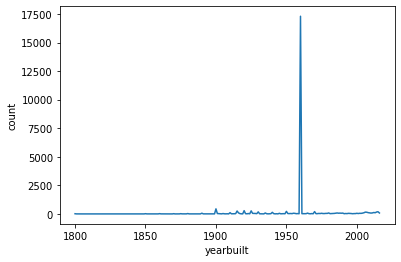

In [18]:
preprocessed_data = preprocessing(train_data)
plot_data(preprocessed_data, 'yearbuilt', 'count')

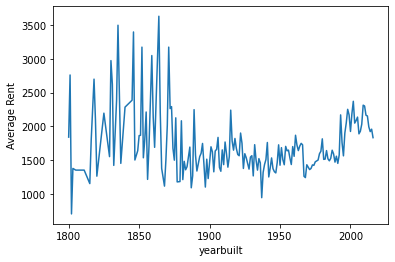

In [19]:
plot_data(preprocessed_data, 'yearbuilt', 'mean')

it seems home built before 1900 have higher rent (will add new feature on year built range)

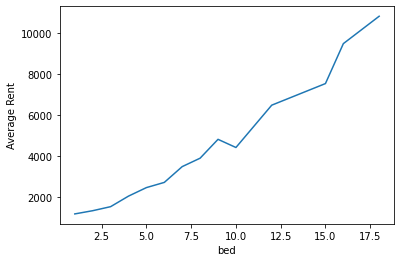

In [20]:
plot_data(preprocessed_data, 'bed', 'mean')

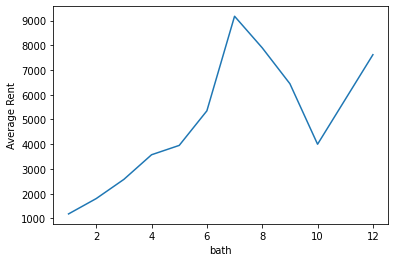

In [21]:
plot_data(preprocessed_data, 'bath', 'mean')

Average rent have different trend for 0-7, 7-10 and > 10

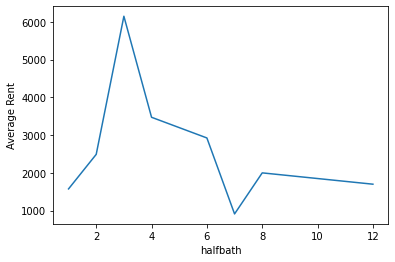

In [22]:
plot_data(preprocessed_data, 'halfbath', 'mean')

Average rent have different trend for 0-3, 3-7 and > 7

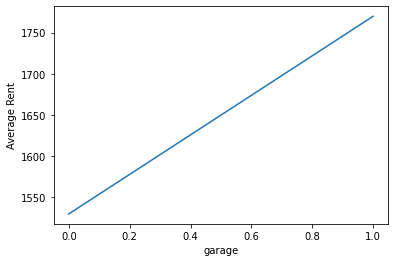

In [23]:
plot_data(preprocessed_data, 'garage', 'mean')

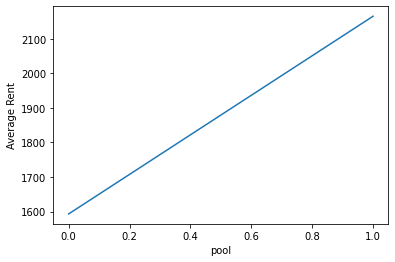

In [24]:
plot_data(preprocessed_data, 'pool', 'mean')

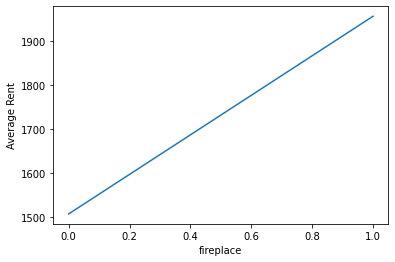

In [25]:
plot_data(preprocessed_data, 'fireplace', 'mean')

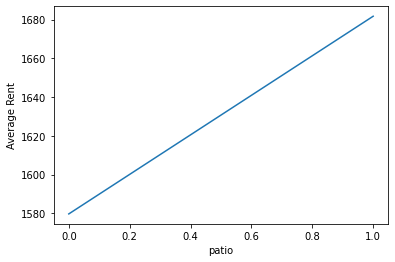

In [26]:
plot_data(preprocessed_data, 'patio', 'mean')

there is no mazor difference in average rent on two classes, so we can ignore this feature

In [27]:
class FeatureEngineering(object):
  """class to perform all Feature Enginerring task"""
  def yearbuilt_range(self, x):
    if x < 1900:
      return 'less_1900'
    elif x >=1900 and x <= 1960:
      return '1900-1960'
    else:
      return 'grt_1960'
  
  def bath_range(self, x):
    if x < 7:
      return 'bath-less_7'
    elif x >=7 and x <= 10:
      return 'bath-7-10'
    else:
      return 'bath-grt_10'

  def halfbath_range(self, x):
    if x < 3:
      return 'hb-less_3'
    elif x >= 3 and x <= 7:
      return 'hb-3-7'
    else:
      return 'hb-grt_7'

  def add_zipcode(self, x):
    return dict_zip_code.get(x, default_zipcode)

  def add_city(self, x):
    return dict_city.get(x, default_city)

  def add_county(self, x):
    return dict_county[x]

  def add_new_features(self, data):
    data['yearbuilt_range'] = data['yearbuilt'].apply(self.yearbuilt_range)
    data['bath_range'] = data['bath'].apply(self.bath_range)
    data['halfbath_range'] = data['halfbath'].apply(self.halfbath_range)
    data['zipcode'] = data['zipcode'].apply(self.add_zipcode)
    data['city'] = data['city'].apply(self.add_city)
    data['county'] = data['county'].apply(self.add_county)
    #Create dummies
    df_property_type = pd.get_dummies(data['property_type'])
    df_yearbuilt_range = pd.get_dummies(data['yearbuilt_range'])
    df_bath_range = pd.get_dummies(data['bath_range'])
    df_halfbath_range = pd.get_dummies(data['halfbath_range'])

    #Merge All data
    data.reset_index(drop=True, inplace=True)
    df_property_type.reset_index(drop=True, inplace=True)
    df_yearbuilt_range.reset_index(drop=True, inplace=True)
    df_bath_range.reset_index(drop=True, inplace=True)
    df_halfbath_range.reset_index(drop=True, inplace=True)
    engg_data = pd.concat([data, df_property_type, df_yearbuilt_range, df_bath_range, df_halfbath_range], axis=1)
    return engg_data

**DataPrep**

In [28]:
#dentist_dist_miles, patio, state
#constant value for state
def get_training_data(data):
  """Define traing and validation data"""
  preprocessed_data = preprocessing(data)
  feat_engg = FeatureEngineering()
  engg_data = feat_engg.add_new_features(preprocessed_data)
  engg_data = engg_data.sample(frac=1)
  train, test = train_test_split(engg_data, test_size=0.2)

  FEATURE_COLUMNS = ['Census_MedianIncome', 'starbucks_miles', 'sqft', 'hospital_miles', 'railline_miles', 'opt_dist_miles', 'walmart_miles', 
                   'Unemployment', 'physician_dist_miles', 'lotsize', 'longitude', 'farmers_miles','Crime_Rate', 'EmploymentDiversity', 
                   'nationalhighway_miles', 'cemetery_dist_miles', 'latitude',
                    'vet_dist_miles', 'bed', 'city', 'zipcode', 'pool', 'garage', 'fireplace','county', 'Condo', 'Duplex', 'Quadplex',
                    'SFR', 'Triplex', '1900-1960', 'less_1900', 'grt_1960', 'bath-7-10', 'bath-less_7',
                    'bath-grt_10', 'hb-3-7', 'hb-less_3', 'hb-grt_7']
  train_x = train[FEATURE_COLUMNS]
  train_y = train['rent']
  test_x = test[FEATURE_COLUMNS]
  test_y = test['rent']
  return train_x, train_y, test_x, test_y

**Model**

In [167]:
class MyModel(object):
  """ class for all models"""
  def dnn(self):
    inputs = tf.keras.layers.Input(shape=39)
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    out = tf.keras.layers.Dense(1)(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse', metrics=['mse'])
    return model

  def xgb(self):
    xgb = xgboost.XGBRegressor(n_estimators=300, max_depth=6, subsample=0.8, colsample_bytree=0.7)
    return xgb

  def lr(self):
    lr = LinearRegression()
    return lr
  def rf(self):
    rf = RandomForestRegressor(n_estimators=50, max_samples=.5, max_features=10)
    return rf
  def knn(self):
    knn = KNeighborsRegressor()
    return knn
MyModel = MyModel()

**Train**

In [168]:
class TrainAndEvaluate(object):
  """class for training and evaluation of model"""
  def evaluate(self, model, test_x, test_y):
    """function for model evaluation"""
    prediction = model.predict(test_x)
    rmse = mean_squared_error(test_y, prediction, squared=False)
    r2_scr = r2_score(test_y, prediction)
    return rmse, r2_scr
  
  def train_and_evaluate(self, train_x, train_y, test_x, test_y):
    """function for model training"""
    rmse_eval = {}
    r2_eval = {}
    #Train xgb Model
    xgb_model = MyModel.xgb()
    xgb_model.fit(train_x, train_y)
    rmse, r2_scr = self.evaluate(xgb_model, test_x, test_y)
    rmse_eval['xgb'] = rmse
    r2_eval['xgb'] = r2_scr
    #Train Linear Regression
    lr_model = MyModel.lr()
    lr_model.fit(train_x, train_y)
    rmse, r2_scr = self.evaluate(lr_model, test_x, test_y)
    rmse_eval['lr'] = rmse
    r2_eval['lr'] = r2_scr
    #Train Random Forest
    rf_model = MyModel.rf()
    rf_model.fit(train_x, train_y)
    rmse, r2_scr = self.evaluate(rf_model, test_x, test_y)
    rmse_eval['rf'] = rmse
    r2_eval['rf'] = r2_scr
    #Train KNN
    knn_model = MyModel.knn()
    knn_model.fit(train_x, train_y)
    rmse, r2_scr = self.evaluate(knn_model, test_x, test_y)
    rmse_eval['knn'] = rmse
    r2_eval['knn'] = r2_scr
    #Train DNN
    dnn_model = MyModel.dnn()
    dnn_model.fit(train_x, train_y, epochs=50, verbose=0)
    rmse, r2_scr = self.evaluate(dnn_model, test_x, test_y)
    rmse_eval['dnn'] = rmse
    r2_eval['dnn'] = r2_scr
    return rmse_eval, r2_eval, xgb_model, lr_model, rf_model, knn_model, dnn_model
train_and_evaluate = TrainAndEvaluate()

In [169]:
train_x, train_y, test_x, test_y = get_training_data(train_data)
rmse_eval, r2_eval, xgb_model, lr_model, rf_model, knn_model, dnn_model = train_and_evaluate.train_and_evaluate(train_x, train_y, test_x, test_y)
print("Root Mean Squared Error:", rmse_eval)
print("R2 Score:", r2_eval)

[15:25:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Root Mean Squared Error: {'xgb': 376.941412178043, 'lr': 616.5583410574995, 'rf': 430.7489499312025, 'knn': 523.9444605038062, 'dnn': 603.58455441859}
R2 Score: {'xgb': 0.8534782167321052, 'lr': 0.6079848565542959, 'rf': 0.8086612449192347, 'knn': 0.7169096956932153, 'dnn': 0.6243090576471974}


Text(0, 0.5, 'RMSE')

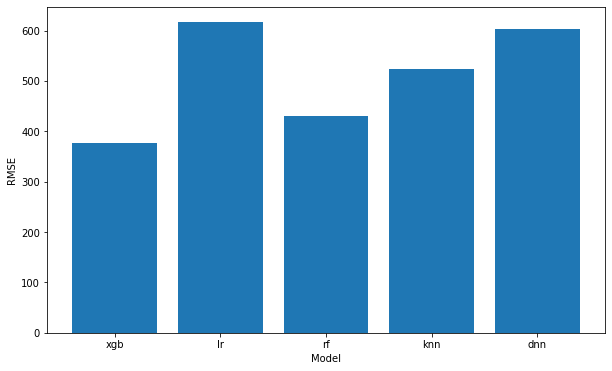

In [170]:
plt.figure(figsize=(10,6))
plt.bar(rmse_eval.keys(), rmse_eval.values())
plt.xlabel("Model")
plt.ylabel("RMSE")

Text(0, 0.5, 'R2 Score')

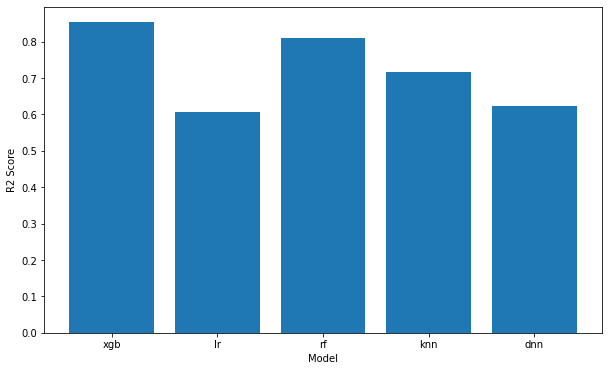

In [171]:
plt.figure(figsize=(10,6))
plt.bar(r2_eval.keys(), r2_eval.values())
plt.xlabel("Model")
plt.ylabel("R2 Score")

In [172]:
print("XGBoost performed best")
print("================")
print("Training Metrics")
print("RMSE: {} R2Score: {}".format(mean_squared_error(train_y, xgb_model.predict(train_x), squared=False), 
                                    r2_score(train_y, xgb_model.predict(train_x))))
print("================")
print("Testing Metrics")
print("RMSE: {} R2Score: {}".format(mean_squared_error(test_y, xgb_model.predict(test_x), squared=False), 
                                    r2_score(test_y, xgb_model.predict(test_x))))

XGBoost performed best
Training Metrics
RMSE: 236.98868135241852 R2Score: 0.9303786089719444
Testing Metrics
RMSE: 376.941412178043 R2Score: 0.8534782167321052


**Prediction**

In [176]:
test_data = pd.read_csv('/content/test.csv')
test_data['rent'] = 0
all_ids = test_data['id'].values

In [177]:
def get_testing_data(data):
  preprocessed_data = preprocessing(data)
  feat_engg = FeatureEngineering()
  engg_data = feat_engg.add_new_features(preprocessed_data)
  FEATURE_COLUMNS = ['Census_MedianIncome', 'starbucks_miles', 'sqft', 'hospital_miles', 'railline_miles', 'opt_dist_miles', 'walmart_miles', 
                   'Unemployment', 'physician_dist_miles', 'lotsize', 'longitude', 'farmers_miles','Crime_Rate', 'EmploymentDiversity', 
                   'nationalhighway_miles', 'cemetery_dist_miles', 'latitude',
                    'vet_dist_miles', 'bed', 'city', 'zipcode', 'pool', 'garage', 'fireplace','county', 'Condo', 'Duplex', 'Quadplex',
                    'SFR', 'Triplex', '1900-1960', 'less_1900', 'grt_1960', 'bath-7-10', 'bath-less_7',
                    'bath-grt_10', 'hb-3-7', 'hb-less_3', 'hb-grt_7']
  missing_columns = set(FEATURE_COLUMNS) - set(engg_data.columns)
  for col in missing_columns:
    engg_data[col] = 0
  pred_x = engg_data[FEATURE_COLUMNS]
  return pred_x

In [178]:
pred_x = get_testing_data(test_data)
rent_predictions = xgb_model.predict(pred_x)
submission_df = pd.DataFrame(data=all_ids, columns=['id'])
submission_df['rent'] = rent_predictions
submission_df = submission_df.astype({'rent':int})
submission_df.to_csv("submission.csv", index=False)